# Terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

In [1]:
%matplotlib inline
import anndata
import novosparc
import os
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

# Reading data
I got the data from Anna & Tancredi. The spatial file is 6w tumor slide, spatial in-house method processed with spacemake. The other data is annotated single-nuclei data, exported by Anna. Method details - idk.

The data is located in Anna's home directory on the lab server:
`/data/local/rajewsky/home/aantona/novaseq/H5AD_snRNA_ST/`
I created a symlink within my own directory:
`/data/local/rajewsky/home/vschuma/NSTT/data/TNBC`

In [3]:
data_dir = 'data' # symlinked to /data/local/rajewsky/home/vschuma/NSTT/data/TNBC_inhouse

# Spatial data

The `spatial_6w_fc51_4.h5ad` file is the processed file from Anna which she imported to seurat, did stuff with it and exported back from seurat --> h5ad. Initally e.g. the spotsize is missing so I think that conversion might be not super clean. So I will also check the raw spacemake output h5ad and I may have to repair some stuff or just use the spacemake output.

In [4]:
%%time
st_file = os.path.join(data_dir,"spatial_6w_fc51_4.h5ad")
adata_st_rdn = sc.read_h5ad(st_file) # this is ~10GB RAM
print(adata_st_rdn)

# for spatial annotation: create the obsm from the "y_pos", "x_pos"
locations = pd.DataFrame(list(zip(adata_st_rdn.obs["x_pos"], adata_st_rdn.obs["y_pos"])),
                         columns=['xcoord', 'ycoord'])
num_locations = locations.shape[0] # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori
adata_st_rdn.obsm['spatial'] = locations

AnnData object with n_obs × n_vars = 55478 × 23185
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'V1', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'tile', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT_snn_res.1.5', 'SCT_snn_res.1', 'Annotation_1', 'x_pos'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'
CPU times: user 1min 6s, sys: 7.41 s, total: 1min 13s
Wall time: 2min 30s


/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


### understanding spacemake output

Initially I had some troubles with plotting the data. For better understanding I also investigated the raw data. But in the end I will only work with the processed file.

In [16]:
# st_file_raw_10w = os.path.join(data_dir,"raw_h5ad/raw_spatial_10w_fc51_7.h5ad") # just for testing what
# adata_st_raw_10w = sc.read_h5ad(st_file_raw_10w)
# print(adata_st_raw_10w)

# .uns labled differently - can I give this as ".uns['spatial'][library_id]"?
# adata_st_raw_10w.uns["indices_joined_spatial_units"]
# st_file_raw_6w = os.path.join(data_dir,"raw_h5ad/raw_spatial_6w_fc51_4.h5ad") # just for testing what
# adata_st_raw_6w_rdn = sc.read_h5ad(st_file_raw_6w)
# print(adata_st_raw_6w_rdn)

# .uns missing completely
# type(adata_st_raw_6w.obsm["spatial"])
#adata_st_raw_6w_rdn.obsm["spatial"] # this looks like the coordinates -  but what it "x_pos" and "y_pos" then? --> the same
# len(adata_st_raw_6w_rdn.obsm["spatial"])

### plotting spatial data as it is

In [17]:
# sc.pl.spatial(adata_st_raw_10w, color="total_counts",spot_size=320)

In [18]:
# sc.pl.spatial(st_file_raw_6w, color="total_counts",spot_size=320)

### plotting by using a standard scatter plot

In [19]:
# function from daniel - needed for older outputs of spacemake that didn't have the .uns attribute yet.
def plot_spatial(adata, counts="total_counts", spatial_1_label="Spatial 1", spatial_2_label="Spatial 2", title="Spatial plot"):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0.,0.,1.,1.])
    sc = ax.scatter(-adata.obsm['spatial'][:, 0],
            -adata.obsm['spatial'][:, 1],
                s=0.5, c=adata.obs[counts],
                cmap="viridis")
    ax.axis('tight')
    ax.set_aspect("equal")
    #plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.ylabel(spatial_2_label)
    plt.xlabel(spatial_1_label)
    plt.title(title)
    cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
    cbar.set_label(counts, rotation=270, labelpad=20)

In [20]:
# plot_spatial(adata_st_raw_6w_rdn)

### annotated spatial file
I can plot the raw data now. But in the annotated (from seurat transformed version) the "spatial" annotation is missing. But I think I should be able to just copy that from the raw file to the processed file (?).

But I think for the atlas generation I don't even need the processed file - maybe only for visualization/comparison later. So I leave that an open todo for now. Although - maybe this one is preprocessed and filtered already and it may would make more sense to use this for the basis of the atlas.... I think I will try a very basic version with the raw data first anyway. As soon as the process is working I can then play around with other stuff.

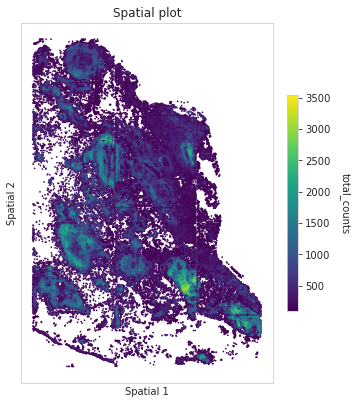

In [21]:
plot_spatial(adata_st_rdn)
# here background (UMI count = 0) is filtered out and also some mitochondrial stuff

# Atlas generation

In [22]:
# deepcopy so I don't have to readin all the time when I want to change smth. Can be removed when the process is clear
adata_st = copy.deepcopy(adata_st_rdn)
adata_st.var_names_make_unique()

In [23]:
sc.pp.highly_variable_genes(adata_st)#, min_mean=0.0125, max_mean=3, min_disp=0.5)

## Extract locations.txt and dge.txt from the anndata object

In [24]:
coord = adata_st.obsm['spatial']
coord_df = pd.DataFrame(data=coord, columns=['xcoord', 'ycoord'])
# coord_df.to_csv('output/TNBC_6w_fc51_4_coordinates.csv', index=False)

## atlas generation based on highly variable genes
This doesn't really seem to work. When sampling markers from the set of highly variable genes - with 50 markers I get already genes that cover the whole tissue/locations space. But apparently it's only genes that are super common there - so I don't get unique set of genes per spot. In fact only ~3% with 50 markers, and only ~4% with 100 markers.
So I think I should reduce the initial gene set I'm sampling from even further.
I can only think about trying "spatially variable" genes next.


## filtering for spatially variable genes


In [25]:
# adata_st.var_names_make_unique()
sq.gr.spatial_neighbors(adata_st, coord_type="generic")
sq.gr.spatial_autocorr(adata_st, mode="moran")

In [26]:
# adata_st.uns["moranI"] = adata_st.uns['moranI'].squeeze()

# ToDo - to get this into a from that I can use as a subsampling subset there are more steps needed:
# 1. filter this for `pval_norm_fdr_bh` < 0.01
# 2. take only the `I` col and write it to .var
# 3. maybe you really need more genes

# ToDo:
# make this script automated for automatically resampling, maybe saving how often it resamples,
# take more genes and also make this automatic and make plots for this

In [27]:
len(adata_st.uns["moranI"])

5328

In [28]:
print(type(adata_st.var['highly_variable']))
print(adata_st.var['highly_variable'].shape)
print(type(adata_st.uns['moranI']))
print(adata_st.uns['moranI'].shape)

<class 'pandas.core.series.Series'>
(23185,)
<class 'pandas.core.frame.DataFrame'>
(5328, 4)


In [31]:
tmp = adata_st.uns["moranI"]["pval_norm_fdr_bh"] <= 0.01
len(tmp[tmp == True])
tmp

Iglv1             True
Epcam             True
Krtap13           True
Csrp3             True
2310079G19Rik     True
                 ...  
Coa7             False
B9d1             False
Gm10443          False
Zfp606           False
Arhgef26          True
Name: pval_norm_fdr_bh, Length: 5328, dtype: bool

In [45]:
# Fixme: This script has a small bug that adds an additional column without a gene name. Causing troubles when reading in later
# The bug is actually that the first column get's the index values and then everything get's shifted - so the

stop = 0
while stop == 0:
    savepath = "output/TNBC_reconstruction_atlas.csv"

    # subsampling from highly variable genes
    # subsample_index = adata_st.var[adata_st.var['highly_variable'] == True].index

    # subsampling from spatially variable genes
    tmp = adata_st.uns["moranI"]["pval_norm_fdr_bh"] <= 0.01
    subsample_index = tmp[tmp == True].index # no index needed I don't have a bool here
    print("size of set to subsample from: ", len(subsample_index))

    # subsampling
    marker_subsample_names = subsample_index.to_frame().sample(600)
    marker_subsample_idx = []
    for gene in marker_subsample_names[0] :
        marker_subsample_idx.append(adata_st.var_names.get_loc(gene))
    marker_subsample = pd.DataFrame(adata_st.X[:, marker_subsample_idx],
                                    columns=marker_subsample_names[0])

    # count sets
    loc_w_gene = 0
    loc_wo_gene = 0
    for idx,row in marker_subsample.iterrows():
        if (row == 0).all():
            loc_wo_gene += 1
        else:
            loc_w_gene += 1
    marker_cov = loc_w_gene/marker_subsample.shape[0]
    print('num loc w gene = {} \n'
          'num loc w/o gene = {}\n'
          'therefore gene marker cov = {}'.format(loc_w_gene, loc_wo_gene, marker_cov))

    # evaluate point uniqueness
    # 1. binarize marker_subsample
    marker_subsample_bin = marker_subsample.mask(marker_subsample > 0, 1 )
    # 2. vector of gene sets
    gene_sets_p_loc = []
    # 3. get gene set per location
    for idx, row in marker_subsample_bin.iterrows():
        gene_sets_p_loc.append(
            tuple(row.index[row.loc[:] == 1])
        )
    # 4. count how many unique sets are in the list
    num_unique = len(set(gene_sets_p_loc))

    # 5. calculate ratio of covered locations that are unique
    unique_cov = num_unique/(marker_subsample.shape[0] - loc_wo_gene)*100
    print("%.1f %% of the marker-locations are unique." % unique_cov)

    # 6. write atlas to file
    if marker_cov == 1.0 and unique_cov >= 99:
        marker_subsample.to_csv(savepath, index_label=False)
        stop = 1
    else:
        print("you should resample before saving this")

# ideas to improve that script (or make an actual script out of it)
# - make everything above step 6 a function that outputs tue marker_cov, unqiue_cov and the marker_subsample thing
# step 6 can be an automated check - that checks the output values and automatically reruns the sampling or stores the output at some point
# there should be an additional time limitation of e.g. 5 or 10 min
# after the time the script stops and e.g. says: "I can find gene sets with X coverage, but only Y uniqueness. Please increase the number of sampled marker or subsample further the inital set"'

size of set to subsample from:  1267
num loc w gene = 55478 
num loc w/o gene = 0
therefore gene marker cov = 1.0
99.2 % of the marker-locations are unique.


In [ ]:
len(adata_st.var[adata_st.var['highly_variable'] == True].index)

# Get "true" spatial annotation

In [6]:
adata_st_rdn.obs["seurat_clusters"]

4840      11
4841      19
4905      19
4906      19
4907      19
          ..
141910     0
141913     2
141914     1
141915     1
141916     1
Name: seurat_clusters, Length: 55478, dtype: int32